# Kalman filter

Using the same notation as the wikipedia

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
I = np.array([[1,0],[0,1]])

def trans_mat(a,b):
    return a @ b @ a.T

def trans_vec(a,b):
    return a @ b

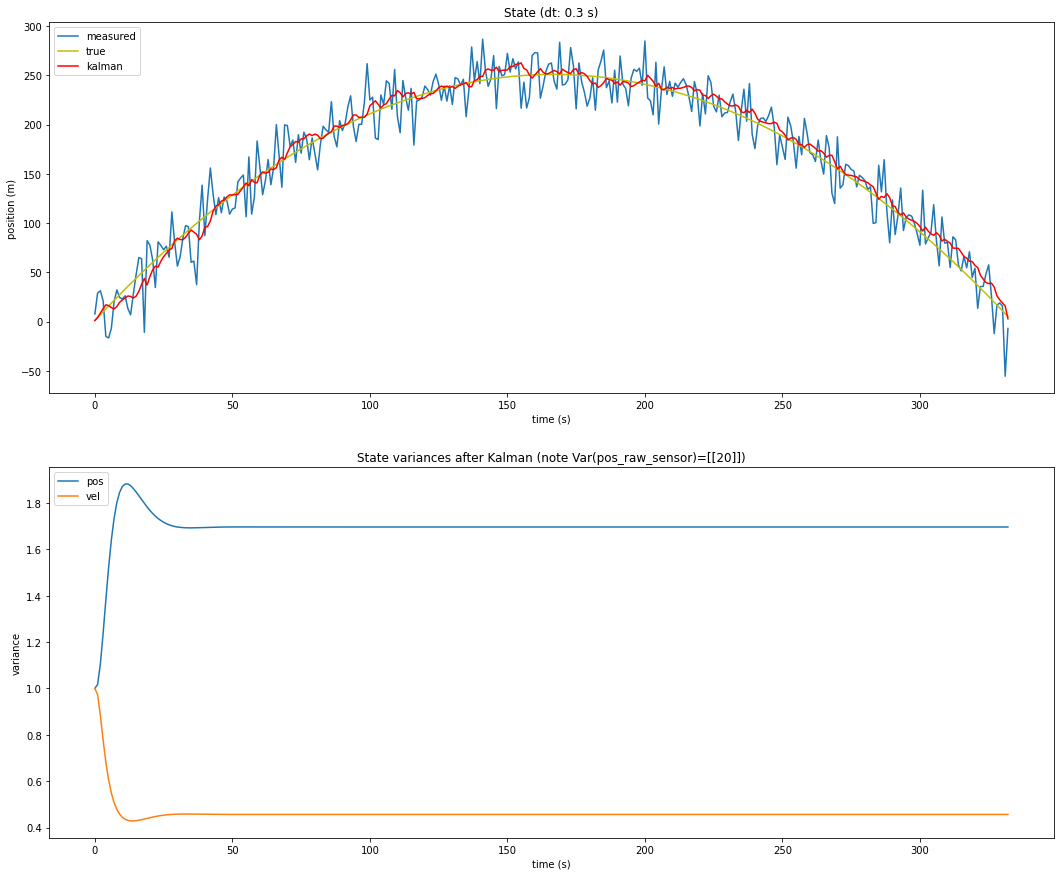

In [3]:
dt = 0.3
pos = 1
vel = 10
acc = -.2

x_true = np.array([pos,vel])

# model (x'=Fx+G)
F = np.array([[1,dt],[0,1]])
G = np.array([0.5*dt*dt, dt])*acc

# observation model
H = np.array([[1,0]])   


def sample_sensor():
    #simulate sensor noise
    muV, sigV  = 1, 20
    N = np.random.normal(0, 1)
    v = (muV + sigV*N)    
    R = np.array([[(sigV)]]) 

    return (H @ x_true) + v, R

def sample_model_distribution():
    muW,sigW = acc, 3
    N = np.random.normal(0, 1)
    w = G*(muW + sigW * N)
    Q = np.outer(G,G)*(sigW**2)
    return w, Q
        
def kalman():    
    global x_true
    sample_rate = 1.0/dt

    x_prev = x_true
    P_prev = np.array([[1,0],[0,1]]) * 1
    P = P_prev
    sensor_err = []
    kalman_err = []

    pt = []
    pm = []
    pk_mu = []
    pk_var = []
    for i in range(int(100*sample_rate)):
        pt.append(x_true[0])
        pk_mu.append(x_prev[0])
        pk_var.append(np.diagonal(np.linalg.cholesky(P)))

        # 1) make a noisy measurement using the sensor
        z, R = sample_sensor()
        pm.append(z[0])

        # 2) make a prediction using the model
        w, Q = sample_model_distribution()
        x_pred = trans_vec(F, x_prev) + ( w )
        P_pred = trans_mat(F, P_prev) + ( Q )

        # compute Kalman gain
        S = trans_mat(H, P_pred) + R
        K = P_pred @ H.T @ np.linalg.inv(S)    
        M = I - (K@H)

        # update state
        x = trans_vec(M, x_pred) + trans_vec(K, z)
        P = trans_mat(M, P_pred) + trans_mat(K, R)

        # track errors

        sensor_err.append(np.abs(x_true - z)[0])
        kalman_err.append(np.abs(x_true - x)[0])

        #step

        # simulate trajectory (for the sensor)
        x_true = trans_vec(F,x_true) + (G)
        x_prev = x
        P_prev = P

        
    pk_mu = np.array(pk_mu)    
    pk_var = np.array(pk_var)    
    fig, ax = plt.subplots(2, 1,figsize=(18,15))
    ax[0].set_title(f'State (dt: {dt} s)')
    ax[0].plot(pm, label="measured")  
    ax[0].plot(pt, color = 'y', label="true")    
    ax[0].plot(pk_mu, color = 'r', label="kalman")  
    ax[0].legend(loc="upper left")
    ax[0].set_xlabel('time (s)')
    ax[0].set_ylabel('position (m)')

    ax[1].set_title(f'State variances after Kalman (note Var(pos_raw_sensor)={R})')
    ax[1].plot(pk_var.T[0], label="pos")    
    ax[1].plot(pk_var.T[1], label="vel")    
    ax[1].set_xlabel('time (s)')
    ax[1].set_ylabel('variance')
    ax[1].legend(loc="upper left")
    
    plt.show()

kalman()

Notes:
- We can add 2 covariance matrices Kx + Ky when every element of the x dist is uncorrelated with every element of y
- When we are reading a sensor we are in reality sampling from a distribution
- Variance = standard deviation = sigma^2 

# Unit tests

In [4]:
# make sure samples and cov matrices match
def check_dist(fn):
    d = []
    for i in range(10000):
        w,Q = fn()
        d.append(w)

    d = np.array(d)    
    cvm = np.cov(d.T)

    print("Provided cov matrix:")
    print(Q)
    print("Computed cov matrix:")
    print(cvm)
    print("similarity (the closer to 100% the better):")
    err = np.zeros_like(Q)
    for j in range(2):
        for i in range(2):
            err[i][j] = Q[i][j]*100/cvm[i][j]
    print(err)
    
    
    
check_dist(sample_model_distribution) 

Provided cov matrix:
[[0.000729 0.00486 ]
 [0.00486  0.0324  ]]
Computed cov matrix:
[[0.00073916 0.00492773]
 [0.00492773 0.03285153]]
similarity (the closer to 100% the better):
[[98.6255425 98.6255425]
 [98.6255425 98.6255425]]


In [5]:
x_true = np.array([4,5])

def check_dist():    
    d = []
    for i in range(10000):
        w,Q = sample_sensor()
        d.append(w)
    print("provided cov matrix:", Q[0][0])
    print("Computed cov matrix:", np.std(d))
    
check_dist()    

provided cov matrix: 20
Computed cov matrix: 19.7402617889635
